# Basic model

author: laquitainesteeve@gmail.com

## Setup 

activate fisher_info_limits

In [ ]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle5 as pickle
from scipy.stats import spearmanr, wilcoxon
from matplotlib.gridspec import GridSpec as GS
import math
from scipy.stats import poisson
from scipy.optimize import minimize_scalar
from scipy.special import radian as rad
from scipy.stats import circstd

# setup project path
main_dir = '/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/'
os.chdir(main_dir)

# import custom package
import ssiProjectModule as ssiMod

# setup parameters
sample_size = 500
theta_step = 2
stim = np.arange(0, 360, theta_step) # stimulus direction space

# setup Bayesian parameters
N_TRIALS = 10000

# setup paths
main_dir = '/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/'
dat_dir_in = main_dir + 'data/decoding_analysis/'
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'

title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

constant = 360/np.sqrt(2*np.pi*math.e)

with open(dat_dir_in + title, 'rb') as rick:
    data_dict = pickle.load(rick)

bio_idx = np.where(data_dict['all_multipliers']==1.)[0][0]

chosen_quads = np.array([201, 125, 104, 491])

## Functions

In [ ]:
# Bayesian (maximum likelihood) decoder

def generate_responses(tuning_curves, true_direction_index, n_trials=10, seed=0):
    """
    Generate Poisson spike counts for all neurons given a true direction.
    
    Parameters:
    - true_diretrue_direction_index: true motion direction index 
    - n_trials: number of trials to simulate
    
    Returns:
    - responses: array of spike counts [n_trials, n_neurons]
    """
    # setup reproducibility
    np.random.seed(seed)

    # parameters
    n_neurons = tuning_curves.shape[1]
    responses = np.zeros((n_trials, n_neurons))
    
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[true_direction_index, n_i]
        responses[:, n_i] = poisson.rvs(mean_firing_rate, size=n_trials)
    return responses


def log_likelihood(direction_index, observed_responses, tuning_curves):
    """Compute log likelihood of observed responses given a direction.
    
    Parameters:
    - direction (float): candidate direction (degrees)
    - observed_responses: observed spike counts for all neurons
    
    Returns:
    - log_likelihood: log probability of the data
    """
    n_neurons = tuning_curves.shape[1]
    direction_index = int(direction_index) # make an integer 

    log_prob = 0
    
    for n_i in range(n_neurons):

        mean_firing_rate = tuning_curves[direction_index, n_i]
        
        # Poisson log likelihood ( sum(r * ln(mean_r) - mean_r) )
        log_prob += observed_responses[n_i] * np.log(mean_firing_rate + 1e-10) - mean_firing_rate
    return log_prob


def decode_direction(observed_responses, tuning_curves, bounds=(0,180)):
    """decode direction using maximum likelihood estimation (flat prior).
    
    Parameters:
    - observed_responses: observed spike counts for all neurons
    
    Returns:
    - decoded direction index: estimated direction index (integer)
    """
    # define negative log likelihood function for optimization
    def neg_log_likelihood(direction_index):
        return -log_likelihood(direction_index, observed_responses, tuning_curves)
    
    # search over full range of directions
    result = minimize_scalar(neg_log_likelihood, bounds=bounds, method='bounded')
    return int(result.x)


def compute_bayesian_decoding_error(true_directions, tuning_c, n_trials=100, seed=0):

    all_true_dirs = []
    all_decoded_dirs = []
    all_errors = []

    # loop over stimulus in stimulus space
    for dir_ix, true_dir in enumerate(true_directions):

        # (n trials, 4 neurons) responses
        responses = generate_responses(tuning_c.T, int(dir_ix), n_trials=n_trials, seed=seed)

        # loop over many trials
        for trial in range(n_trials):
            
            # decode each trial
            decoded_dir_ix = decode_direction(responses[trial,:], 
                                              tuning_c.T, 
                                              bounds=(0, len(true_directions)))
            decoded_dir = true_directions[decoded_dir_ix]

            # compute circular error
            error = min(abs(decoded_dir - true_dir), 360 - abs(decoded_dir - true_dir))       

            # record
            all_true_dirs.append(true_dir)
            all_decoded_dirs.append(decoded_dir)
            all_errors.append(error)         

    all_true_dirs = np.array(all_true_dirs)
    all_decoded_dirs = np.array(all_decoded_dirs)
    all_errors = np.array(all_errors)

    # calculate estimate errors as std
    stds = []
    for _, true_dir in enumerate(true_directions):
        this_true_dir_pos = all_true_dirs== true_dir
        std = np.sqrt((all_errors[this_true_dir_pos]**2).mean())
        stds.append(std)
    stds = np.array(stds)

    return {
        'true_directions': all_true_dirs,
        'decoded_directions': all_decoded_dirs,
        'errors': all_errors,
        'stds': stds
    }        

## Compute dataset

### Tuning curves

In [212]:
# setup parameters
N_NEURONS = 4
AMPLITUDE = 4000
WIDTH = 0.5
BASELINE = 0

# setup the preferred angle of each neuron
preferred_angles = np.linspace(0, 360, N_NEURONS, endpoint=False) 
print('Preferred angles:', preferred_angles)

# create tuning curves
tuning_c = []
for ix, pref_angle  in enumerate(preferred_angles):
    tuning_c.append(ssiMod.VON_MISES(th=stim, a=AMPLITUDE, th_0=pref_angle, s=WIDTH, baseline=BASELINE))
tuning_c = np.array(tuning_c)
print("tuning curve shape:", tuning_c.shape)

Preferred angles: [  0.  90. 180. 270.]
tuning curve shape: (4, 180)


In [ ]:

rad({0, 0], 0, 0)



SyntaxError: closing parenthesis ']' does not match opening parenthesis '{' (1853657942.py, line 1)

## Compute metrics

### Fisher information

In [213]:
%%time 

# compute fisher information
fisher_info = ssiMod.FISHER_POISSON(stim, tuning_c)
print("Fisher info shape:", fisher_info.shape)

# compute fisher error (flat prior, unbiased estimator)
fisher_error = 1/np.sqrt(fisher_info)

Fisher info shape: (180,)
CPU times: user 618 µs, sys: 581 µs, total: 1.2 ms
Wall time: 1.37 ms


### Bayesian decoding error

In [214]:
%%time

# compute bayesian decoding mean squared error
results = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0)

# unit-test
assert sum(results['true_directions']==stim[0])== 1000

AssertionError: 

## Plot

/var/folders/_k/b_712yyj7vn5l6zfgz7s3xmc0000gn/T/ipykernel_83889/1883248964.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


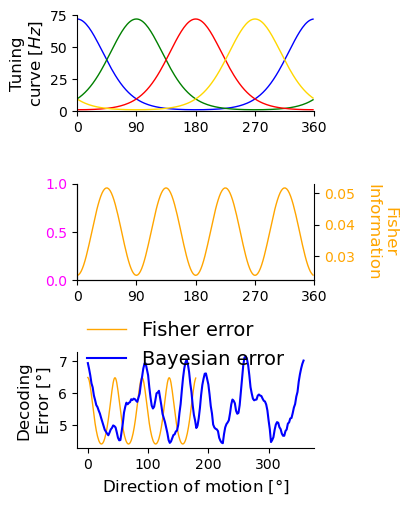

In [215]:
labelsize = 12
legend_fontsize = 14
text_size = 14
tick_labelsize = 10
lw = 1

plt.rcParams['xtick.labelsize']=tick_labelsize
plt.rcParams['ytick.labelsize']=tick_labelsize
mpl.rcParams['axes.spines.right']=False

# setup plot
fig = plt.figure(figsize=(15, 10))
gs = GS(5, 4, wspace=0.3, hspace=0.75)
colors = ['blue', 'green', 'red', 'gold']

# Tuning curves ----------------
ax = fig.add_subplot(gs[0,0])

for j, tc in enumerate(tuning_c):
    ax.plot(stim, tc, color = colors[j], linewidth=lw)

# legend
ax.set_xlim(0,360)
ax.set_ylim(0,75)    
ax.set_xticks(np.arange(0,361, 90))
ax.set_yticks(np.arange(0,76, 25))

# Fisher information ----------------
ax1 = fig.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax2.plot(stim, fisher_info, color = 'orange', linewidth=lw)
ax2.spines['right'].set_visible(True)
ax1.tick_params('y', labelcolor = 'magenta')
ax2.tick_params('y', labelcolor = 'orange')
ax1.set_xlim(0,360)
ax1.set_xticks(np.arange(0,361, 90))
# ax1.set_ylabel('Sensitivity\n'+r'[$Bits$]', color = 'magenta', size = labelsize)

ax.yaxis.set_label_coords(-0.135, y=0.5)
ax.set_ylabel('Tuning\n'+r'curve [$Hz$]', size = labelsize)  

ax2.yaxis.set_label_coords(1.35, y=0.5)
ax2.set_ylabel('Fisher\n'+r'Information', rotation=270, color = 'orange', size = labelsize)        


#gs.update(left=0.055,right=0.925,top=0.95,bottom=0.05)#,wspace=0.3,hspace=0.5)
#ax2.set_xlabel(r'Direction of motion [$\degree$]', size = labelsize)

ax3 = fig.add_subplot(gs[2,0])
ax3.plot(fisher_error, color = 'orange', linewidth=lw, label='Fisher error')
ax3.set_xlabel('Direction of motion [$\degree$]', size = labelsize)
ax3.set_ylabel('Decoding\n'+r'Error [$\degree$]', size = labelsize)  

ax3.plot(stim, results['stds'], color = 'blue', label='Bayesian error')
ax3.legend(frameon=False, fontsize = legend_fontsize, loc=(0.01, 0.75))

plt.tight_layout()
# plt.legend()

# plt.savefig('basic_model_fisher_info.svg', bbox_inches='tight', dpi = 300)